In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sghmc

In [2]:
pima = np.genfromtxt('pima-indians-diabetes.data', delimiter=',')
names = ["Number of times pregnant",
         "Plasma glucose concentration",
         "Diastolic blood pressure (mm Hg)",
         "Triceps skin fold thickness (mm)",
         "2-Hour serum insulin (mu U/ml)",
         "Body mass index (weight in kg/(height in m)^2)",
         "Diabetes pedigree function",
         "Age (years)",
         "Class variable (0 or 1)"]

In [3]:
# Load data
X = np.concatenate((np.ones((pima.shape[0],1)),pima[:,0:8]), axis=1)
Y = pima[:,8]

Xs = (X - np.mean(X, axis=0))/np.concatenate((np.ones(1),np.std(X[:,1:], axis=0)))
Xs = Xs[:,1:]

n, p = Xs.shape

### Regression

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
# Unscaled
mod_logis = LogisticRegression(fit_intercept=False, C=1e50)
mod_logis.fit(X,Y)
beta_true_unscale = mod_logis.coef_.ravel()
beta_true_unscale

array([ -8.31498612e+00,   1.22560027e-01,   3.49183220e-02,
        -1.34118967e-02,   6.28219471e-04,  -1.17179659e-03,
         8.86606033e-02,   9.30419443e-01,   1.46781178e-02])

In [6]:
# Scaled
mod_logis = LogisticRegression(fit_intercept=False, C=1e50)
mod_logis.fit(Xs,Y)
beta_true_scale = mod_logis.coef_.ravel()
beta_true_scale

array([ 0.39024907,  1.08791914, -0.24544979,  0.02250608, -0.1621995 ,
        0.59035938,  0.32483104,  0.12120845])

### HMC

In [28]:
# HMC - Scaled
nsample = 1000
m = 20
eps = .001
theta = np.zeros(p)
#theta = beta_true_unscale.copy()
phi = 5
M = np.identity(p)

samples_hmc, accept, rho, H_hmc = sghmc.run_hmc(Y, Xs, sghmc.U_logistic, sghmc.gradU_logistic, M, eps, m, theta, phi, nsample)

beta_est_hmc = np.mean(samples, axis=0)
beta_est_hmc - beta_true_scale

array([ 0.00275161, -0.04635411,  0.02684351,  0.01217262,  0.00530185,
       -0.02378734, -0.0060964 , -0.01231704])

In [23]:
plt.plot((samples - beta_true_scale)[:,1])
plt.savefig('hmc-trace.pdf')

In [24]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(H)
ax.set_title("Total energy")
ax.set_xlabel("Number of samples")
plt.savefig('hmc-energy.pdf')

In [25]:
fig, ax = plt.subplots(3,1, figsize=(6,10))

i = 0
ax[0].plot((samples - beta_true_scale)[:,i])
ax[0].set_title(names[i])


i = 1
ax[1].plot((samples - beta_true_scale)[:,i])
ax[1].set_title(names[i])


i = 2
ax[2].plot((samples - beta_true_scale)[:,i])
ax[2].set_title(names[i])

### SGHMC

In [29]:
# HMC - Scaled (no intercept)
nsample = 1000
m = 20
eps = .002
theta = np.zeros(p)
#theta = beta_true_scale.copy()
phi = 5
nbatch = 500
C = 1 * np.identity(p)
V = 0 * np.identity(p)
M = np.identity(p)

samples_sghmc, H_sghmc = sghmc.run_sghmc(Y, Xs, sghmc.U_logistic, sghmc.stogradU_logistic, M, eps, m, theta, C, V, phi, nsample, nbatch)

beta_est_sghmc = np.mean(samples, axis=0)
beta_est_sghmc - beta_true_scale

array([ 0.00275161, -0.04635411,  0.02684351,  0.01217262,  0.00530185,
       -0.02378734, -0.0060964 , -0.01231704])

In [99]:
plt.plot((samples - beta_true_scale)[:,0])
plt.savefig('sghmc-trace.pdf')

In [100]:
plt.plot(H)
plt.savefig('sghmc-energy.pdf')

In [31]:
fig, ax = plt.subplots(3,1, figsize=(6,10))

i = 0
ax[0].plot((samples - beta_true_scale)[:,i])
ax[0].set_title(names[i])


i = 1
ax[1].plot((samples - beta_true_scale)[:,i])
ax[1].set_title(names[i])


i = 2
ax[2].plot((samples - beta_true_scale)[:,i])
ax[2].set_title(names[i])

### Gradient Descent

In [32]:
# Gradient descent - Scaled
np.random.seed(2)
phi = .1

beta_est_gd = sghmc.gd(Y, Xs, sghmc.gradU_logistic, .1, 10000, np.zeros(p), phi)

beta_est_gd - beta_true_scale

array([-0.00056779, -0.001654  ,  0.00055597, -0.00011762,  0.00074642,
       -0.00075326, -0.00043704,  0.00030849])

### Plots

In [14]:
import seaborn as sns
import pandas as pd

In [10]:
tit = sns.load_dataset("titanic")

In [64]:
df = pd.DataFrame(np.vstack((beta_true_scale, 
                  beta_est_hmc, 
                  beta_est_sghmc, 
                  beta_est_gd)).T,
                  columns=['reg','hmc','sghmc','gd'])


[        reg       hmc     sghmc        gd
 0  0.390249  0.393001  0.393001  0.389681
 1  1.087919  1.041565  1.041565  1.086265
 2 -0.245450 -0.218606 -0.218606 -0.244894
 3  0.022506  0.034679  0.034679  0.022388
 4 -0.162200 -0.156898 -0.156898 -0.161453
 5  0.590359  0.566572  0.566572  0.589606
 6  0.324831  0.318735  0.318735  0.324394
 7  0.121208  0.108891  0.108891  0.121517, array([0, 1, 2, 3, 4, 5, 6])]

In [122]:
df = pd.DataFrame({'reg': beta_true_scale,
              'hmc': beta_est_hmc,
              'sghmc': beta_est_sghmc,
              'gd': beta_est_gd,
              'name':names[:-1]})
that = (85, 62, 54, 20)
means_reg = tuple(df[["reg"]].values.tolist())
int(means_reg)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [120]:
# data to plot
n_groups = 8
means_reg = tuple(df[["reg"]].values.tolist())
means_sghmc = tuple(df[["sghmc"]].values.tolist())
means_gd = tuple(df[["gd"]].values.tolist())
means_hmc = tuple(df[["hmc"]].values.tolist())
nam = tuple(df[["name"]].values.tolist())



 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, means_reg, bar_width,
                 alpha=opacity,
                 color='b',
                 label='MLE')
 
rects2 = plt.bar(index+bar_width, means_gd, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Gradient Descent')

rects3 = plt.bar(index, means_hmc, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Hamiltonian Monte Carlo')

rects4 = plt.bar(index, means_sghmc, bar_width,
                 alpha=opacity,
                 color='y',
                 label='Stochastic Gradient HMC')
 
plt.xlabel('Coefficient')
plt.ylabel('Value')
plt.title('Scores by person')
plt.xticks(index + bar_width, nam)
plt.legend()
 
plt.tight_layout()
plt.show()

TypeError: '<' not supported between instances of 'list' and 'int'

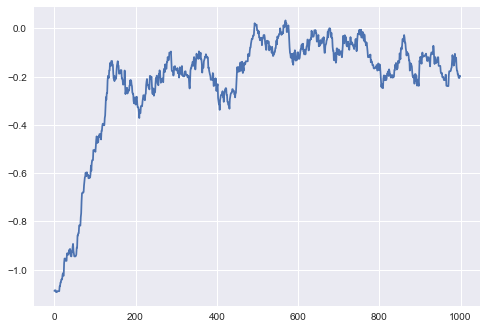

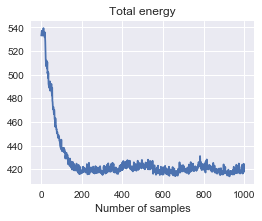

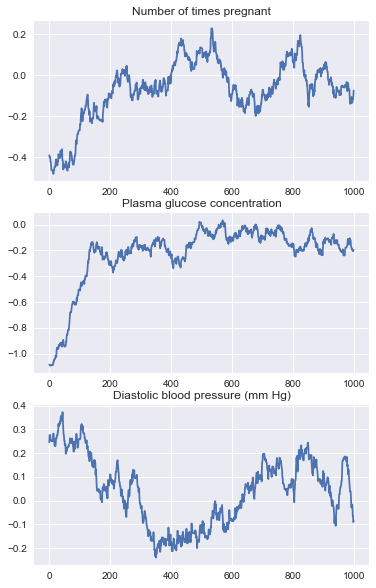

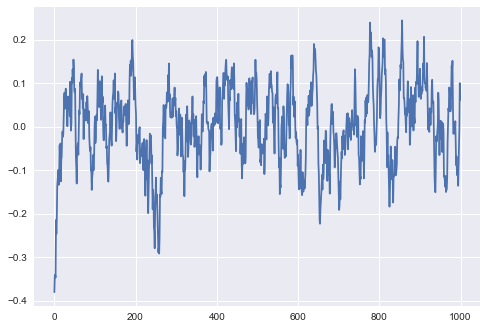

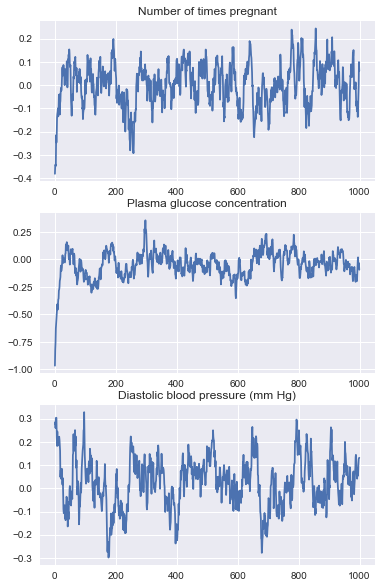

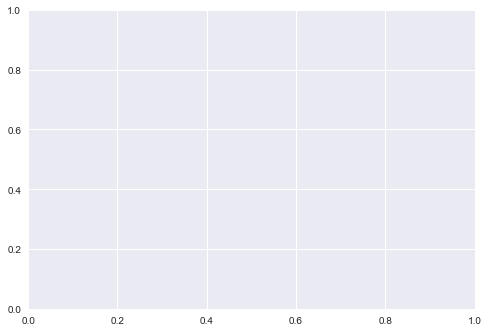

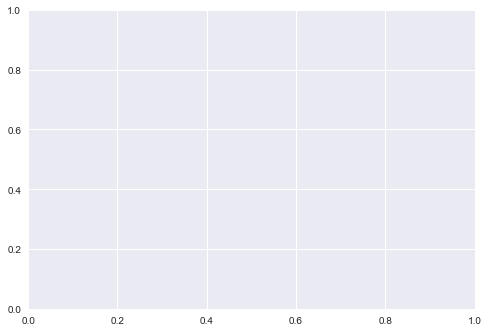

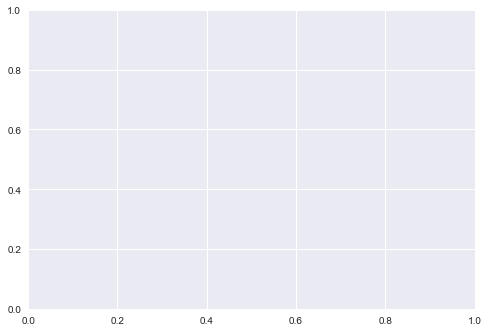

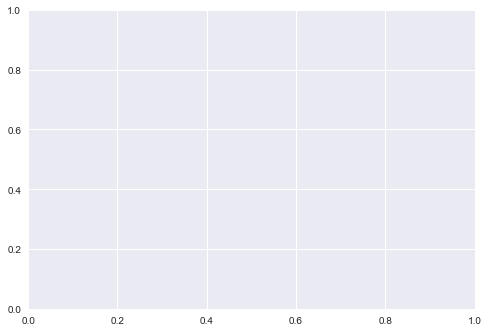

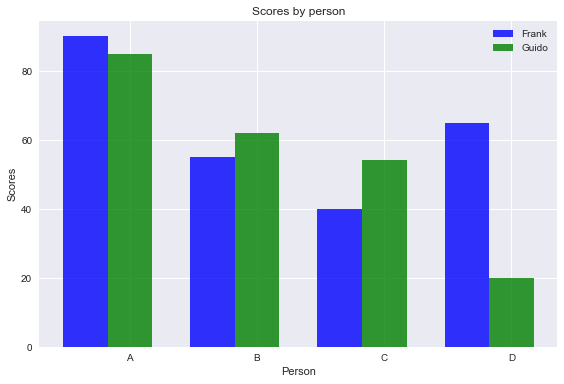

In [98]:
# data to plot
n_groups = 4
means_frank = (90, 55, 40, 65)
means_guido = (85, 62, 54, 20)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, means_frank, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Frank')
 
rects2 = plt.bar(index + bar_width, means_guido, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Guido')
 
plt.xlabel('Person')
plt.ylabel('Scores')
plt.title('Scores by person')
plt.xticks(index + bar_width, ('A', 'B', 'C', 'D'))
plt.legend()
 
plt.tight_layout()
plt.show()